In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

In [2]:
# load data obtained from each operating conditions at current density of 700 mA/cm^2
as_700 = np.load("Data/wrangled_data/as_700.npy")
cs_700 = np.load("Data/wrangled_data/cs_700.npy")
normal_700 = np.load("Data/wrangled_data/normal_700.npy")

In [3]:
# Create labels for each SoH
label_AS = np.zeros(as_700.shape[0])
label_normal = np.ones(normal_700.shape[0])
label_CS = np.ones(cs_700.shape[0]) * 2

In [4]:
X = np.vstack((as_700, normal_700, cs_700))
Y = np.hstack((label_AS, label_normal, label_CS))

In [5]:
train_split = 0.80

In [6]:
# chronological split

X_time_train = np.vstack((np.vstack((as_700[0:round(as_700.shape[0] * train_split), :],
                                   normal_700[0:round(normal_700.shape[0] * train_split), :])),
                        cs_700[0:round(cs_700.shape[0] * train_split), :]))
y_time_train = np.hstack((np.hstack((label_AS[0:round(label_AS.shape[0] * train_split)],
                                    label_normal[0:round(label_normal.shape[0] * train_split)])),
                         label_CS[0:round(label_CS.shape[0] * train_split)]))
X_time_test = np.vstack((np.vstack((as_700[round(as_700.shape[0] * train_split):, :],
                                  normal_700[round(normal_700.shape[0] * train_split):, :])),
                       cs_700[round(cs_700.shape[0] * train_split):, :]))
y_time_test = np.hstack((np.hstack((label_AS[round(as_700.shape[0] * train_split):],
                                   label_normal[round(normal_700.shape[0] * train_split):])),
                        label_CS[round(cs_700.shape[0] * train_split):]))

In [7]:
from sklearn.metrics import roc_auc_score, roc_curve, auc, classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit


In [8]:
def confusion_matrix_plot(conf_mat: np.ndarray, model_name: str, split_type: int) -> plt.Figure:
    ax = plt.axes()
    sns.heatmap(np.array(conf_mat), annot=True, cmap="BuGn", fmt="g")


    ax.set_xlabel("Predicted label")
    ax.set_ylabel("True label")
    plt.show()   


In [9]:
rfc_param_grid = {'max_depth': [ 5, 25, 50, 75, 100], 
                  'n_estimators': [5, 25, 50, 75, 100]}
rfc = RandomForestClassifier(random_state=1234)
tscv = TimeSeriesSplit(n_splits=5)
rfc_grid_search = GridSearchCV(estimator=rfc, param_grid=rfc_param_grid, cv=tscv, verbose=3)
rfc_grid_search.fit(X_time_train, y_time_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5] END .......max_depth=5, n_estimators=5;, score=0.814 total time=   0.0s
[CV 2/5] END .......max_depth=5, n_estimators=5;, score=0.814 total time=   0.0s
[CV 3/5] END .......max_depth=5, n_estimators=5;, score=1.000 total time=   0.0s
[CV 4/5] END .......max_depth=5, n_estimators=5;, score=0.128 total time=   0.0s
[CV 5/5] END .......max_depth=5, n_estimators=5;, score=0.651 total time=   0.0s
[CV 1/5] END ......max_depth=5, n_estimators=25;, score=0.814 total time=   0.0s
[CV 2/5] END ......max_depth=5, n_estimators=25;, score=0.837 total time=   0.1s
[CV 3/5] END ......max_depth=5, n_estimators=25;, score=0.988 total time=   0.1s
[CV 4/5] END ......max_depth=5, n_estimators=25;, score=0.140 total time=   0.2s
[CV 5/5] END ......max_depth=5, n_estimators=25;, score=0.721 total time=   0.4s
[CV 1/5] END ......max_depth=5, n_estimators=50;, score=0.814 total time=   0.1s
[CV 2/5] END ......max_depth=5, n_estimators=50

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=RandomForestClassifier(random_state=1234),
             param_grid={'max_depth': [5, 25, 50, 75, 100],
                         'n_estimators': [5, 25, 50, 75, 100]},
             verbose=3)

In [10]:
rfc_grid_search.best_params_

{'max_depth': 25, 'n_estimators': 50}

In [11]:
rfc_grid_search.best_estimator_

RandomForestClassifier(max_depth=25, n_estimators=50, random_state=1234)

[[37  2  1]
 [ 0 50  0]
 [ 3  0 37]]
Classification report: 
              precision    recall  f1-score   support

         0.0       0.93      0.93      0.93        40
         1.0       0.96      1.00      0.98        50
         2.0       0.97      0.93      0.95        40

    accuracy                           0.95       130
   macro avg       0.95      0.95      0.95       130
weighted avg       0.95      0.95      0.95       130

Accuracy:  0.9538461538461539


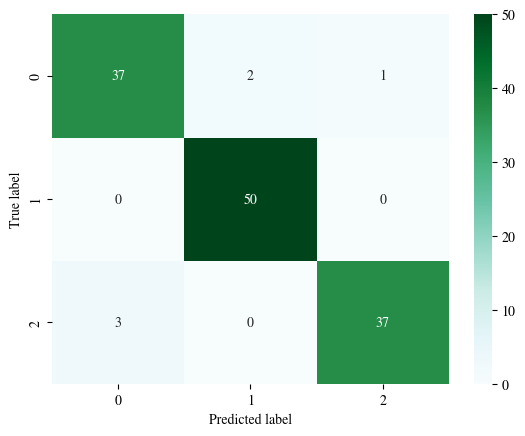

In [12]:
rfc_time = make_pipeline(rfc_grid_search.best_estimator_)
rfc_time.fit(X_time_train, y_time_train)
y_time_pred = rfc_time.predict(X_time_test)
y_time_pred_prob = rfc_time.predict_proba(X_time_test)
rfc_time_result = confusion_matrix(y_time_test, y_time_pred)
print(rfc_time_result)
rfc_time_result1 = classification_report(y_time_test, y_time_pred)
print("Classification report: ")
print(rfc_time_result1)
rfc_time_acc = accuracy_score(y_time_test,y_time_pred)
print("Accuracy: ", rfc_time_acc)

confusion_matrix_plot(rfc_time_result, "Random Forest", 0)


In [13]:
# Hyper parameter tuning for knn - COMMENT OUT IF YOU DON'T WANT TO RUN (TAKES A LONG TIME)
n_neighbors = list(range(1,5))
p = [1,2]
#Convert to dictionary
hyperparameters = dict(n_neighbors=n_neighbors, p=p)

#Create new KNN object
knn_2 = KNeighborsClassifier()#Use GridSearch
clf = GridSearchCV(knn_2, hyperparameters, verbose=3, cv=tscv)

#Fit the model
knn_grid_search = clf.fit(X_time_train,y_time_train)
#Print The value of best Hyperparameters
print('Best leaf_size:', knn_grid_search.best_estimator_.get_params()['leaf_size'])
print('Best p:', knn_grid_search.best_estimator_.get_params()['p'])
print('Best n_neighbors:', knn_grid_search.best_estimator_.get_params()['n_neighbors'])

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END ................n_neighbors=1, p=1;, score=0.814 total time=   0.0s
[CV 2/5] END ................n_neighbors=1, p=1;, score=0.860 total time=   0.2s
[CV 3/5] END ................n_neighbors=1, p=1;, score=1.000 total time=   0.3s
[CV 4/5] END ................n_neighbors=1, p=1;, score=0.140 total time=   0.3s
[CV 5/5] END ................n_neighbors=1, p=1;, score=0.640 total time=   0.3s
[CV 1/5] END ................n_neighbors=1, p=2;, score=0.814 total time=   0.0s
[CV 2/5] END ................n_neighbors=1, p=2;, score=0.884 total time=   0.0s


KeyboardInterrupt: 

In [ ]:
knn_grid_search.best_params_

{'n_neighbors': 1, 'p': 2}

Confusion Matrix: 
[[40  0  0]
 [ 0 50  0]
 [11  0 29]]
Classification report: 
              precision    recall  f1-score   support

         0.0       0.78      1.00      0.88        40
         1.0       1.00      1.00      1.00        50
         2.0       1.00      0.72      0.84        40

    accuracy                           0.92       130
   macro avg       0.93      0.91      0.91       130
weighted avg       0.93      0.92      0.91       130

Accuracy:  0.9153846153846154


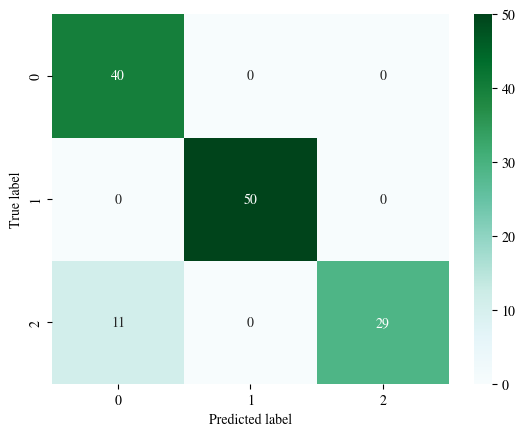

In [ ]:
knn = make_pipeline(StandardScaler(),knn_grid_search.best_estimator_)
knn.fit(X_time_train, y_time_train)
y_time_pred = knn.predict(X_time_test)
y_time_pred_prob = knn.predict_proba(X_time_test)
knn_time_result = confusion_matrix(y_time_test, y_time_pred)
print("Confusion Matrix: ")
print(knn_time_result)
knn_class_report = classification_report(y_time_test, y_time_pred)
print("Classification report: ")
print(knn_class_report)
knn_acc = accuracy_score(y_time_test,y_time_pred)
print("Accuracy: ",knn_acc)

confusion_matrix_plot(knn_time_result, "KNN", 0)

In [14]:

svc_param_grid = { 
    # Regularization parameter.
    "C": [2, 5, 10],
    # Kernel type
    "kernel": ['rbf', 'poly'],
    # Gamma is the Kernel coefficient for ‘rbf’, ‘poly’ and ‘sigmoid’.
    "gamma": [ 2, 5, 10],
    }

svc = SVC(random_state=1234)
svc_grid_search = GridSearchCV(estimator=svc, param_grid=svc_param_grid, cv=tscv, verbose=2)
svc_grid_search.fit(X_time_train, y_time_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] END ...........................C=2, gamma=2, kernel=rbf; total time=   0.0s
[CV] END ...........................C=2, gamma=2, kernel=rbf; total time=   0.6s
[CV] END ...........................C=2, gamma=2, kernel=rbf; total time=   2.2s
[CV] END ...........................C=2, gamma=2, kernel=rbf; total time=   3.3s
[CV] END ...........................C=2, gamma=2, kernel=rbf; total time=   6.3s
[CV] END ..........................C=2, gamma=2, kernel=poly; total time=   0.0s
[CV] END ..........................C=2, gamma=2, kernel=poly; total time=   0.4s
[CV] END ..........................C=2, gamma=2, kernel=poly; total time=   1.0s
[CV] END ..........................C=2, gamma=2, kernel=poly; total time=   1.6s
[CV] END ..........................C=2, gamma=2, kernel=poly; total time=   3.3s
[CV] END ...........................C=2, gamma=5, kernel=rbf; total time=   0.0s
[CV] END ...........................C=2, gamma=5

C:\Users\Abdus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
18 fits failed out of a total of 90.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
18 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Abdus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Abdus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=SVC(random_state=1234),
             param_grid={'C': [2, 5, 10], 'gamma': [2, 5, 10],
                         'kernel': ['rbf', 'poly']},
             verbose=2)

In [15]:
svc_grid_search.best_params_

{'C': 2, 'gamma': 2, 'kernel': 'rbf'}

In [16]:
poly = make_pipeline(svc_grid_search.best_estimator_)
poly.fit(X_time_train, y_time_train)
poly_pred = poly.predict(X_time_test)

Classification report: 
              precision    recall  f1-score   support

         0.0       0.86      0.90      0.88        40
         1.0       0.96      1.00      0.98        50
         2.0       0.94      0.85      0.89        40

    accuracy                           0.92       130
   macro avg       0.92      0.92      0.92       130
weighted avg       0.92      0.92      0.92       130

Accuracy:  0.9230769230769231


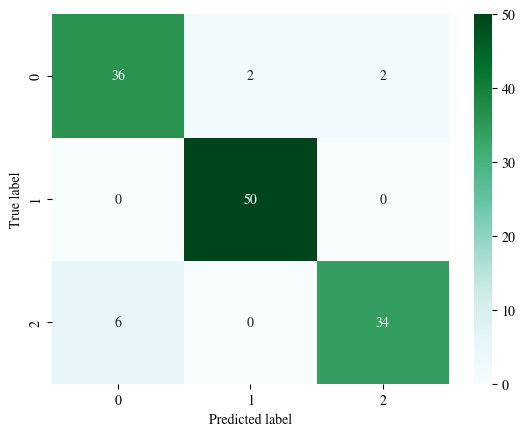

In [17]:
poly_result = confusion_matrix(y_time_test, poly_pred)
poly_classification_rep = classification_report(y_time_test, poly_pred)
print("Classification report: ")
print(poly_classification_rep)
poly_acc = accuracy_score(y_time_test,poly_pred)
print("Accuracy: ", poly_acc)
confusion_matrix_plot(poly_result, "SVM", 0)

Classification report: 
              precision    recall  f1-score   support

         0.0       0.68      0.82      0.74        33
         1.0       0.96      0.98      0.97        53
         2.0       0.89      0.73      0.80        44

    accuracy                           0.85       130
   macro avg       0.84      0.84      0.84       130
weighted avg       0.86      0.85      0.85       130



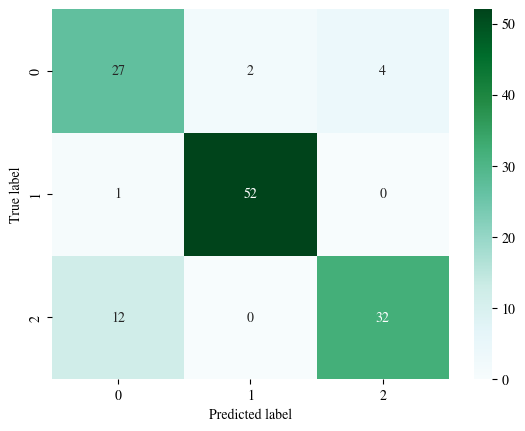

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, train_size=train_split, random_state=1234)

rfc_rand = make_pipeline(rfc_grid_search.best_estimator_)
rfc_rand.fit(X_train, y_train)
y_pred = rfc_rand.predict(X_test)
rfc_result = confusion_matrix(y_test, y_pred)
rfc_result1 = classification_report(y_test, y_pred)
print("Classification report: ")
print(rfc_result1)
rfc_acc = accuracy_score(y_test,y_pred)


confusion_matrix_plot(rfc_result, "Random Forest", 0)

In [19]:
knn = make_pipeline(StandardScaler(),knn_grid_search.best_estimator_)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
knn_result = confusion_matrix(y_test, y_pred)
print("Confusion Matrix: ")
print(knn_result)
knn_class_report = classification_report(y_test, y_pred)
print("Classification report: ")
print(knn_class_report)
knn_acc = accuracy_score(y_test,y_pred)
print("Accuracy: ",knn_acc)

confusion_matrix_plot(knn_result, "KNN", 0)

NameError: name 'knn_grid_search' is not defined

In [ ]:
poly = SVC(C=svc_grid_search.best_params_['C'], gamma=svc_grid_search.best_params_['gamma'],kernel=svc_grid_search.best_params_['kernel'])
poly.fit(X_train, y_train)
y_pred = poly.predict(X_test)
poly_result = confusion_matrix(y_test, y_pred)
print("Confusion Matrix: ")
print(poly_result)
poly_class_report = classification_report(y_test, y_pred)
print("Classification report: ")
print(poly_class_report)
poly_acc = accuracy_score(y_test,y_pred)
print("Accuracy: ",poly_acc)

Confusion Matrix: 
[[25  6  2]
 [ 0 53  0]
 [19  1 24]]
Classification report: 
              precision    recall  f1-score   support

         0.0       0.57      0.76      0.65        33
         1.0       0.88      1.00      0.94        53
         2.0       0.92      0.55      0.69        44

    accuracy                           0.78       130
   macro avg       0.79      0.77      0.76       130
weighted avg       0.82      0.78      0.78       130

Accuracy:  0.7846153846153846


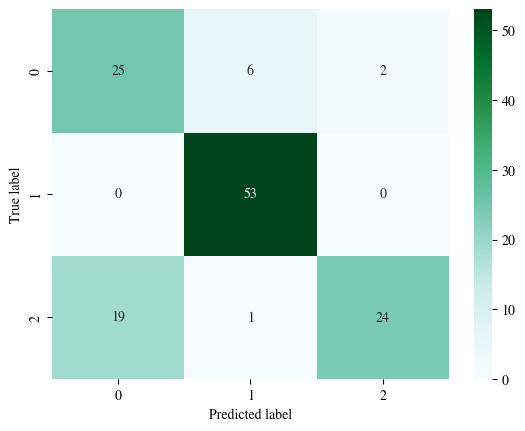

In [ ]:
confusion_matrix_plot(poly_result, "SVM", 0)

In [ ]:
from keras import models, layers, initializers, utils, callbacks
import tensorflow as tf

In [ ]:
train_labels = utils.to_categorical(y_time_train)
train_labels.shape

(520, 3)

In [ ]:
model = models.Sequential(
    [
        layers.Input(shape=(X_time_train.shape[1],1)),
        layers.Conv1D(16, 10, strides=3, activation='relu'),
        layers.MaxPool1D(pool_size=3, strides=3),
        layers.Conv1D(16, 5, strides=2, activation='relu'),
        layers.MaxPool1D(pool_size=2, strides=2),
        #layers.SpatialDropout1D(0.6),
        layers.Flatten(),
        layers.Dense(256, activation='linear'),
        layers.Dense(64, activation='linear'),
        layers.Dropout(0.6),
        layers.Dense(3, activation="softmax")
    ]
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 3331, 16)          176       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 1110, 16)         0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 553, 16)           1296      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 276, 16)          0         
 1D)                                                             
                                                                 
 flatten (Flatten)           (None, 4416)              0         
                                                                 
 dense (Dense)               (None, 256)               1

In [ ]:
es = callbacks.EarlyStopping(monitor='val_accuracy', patience=20)
model.compile(loss="categorical_crossentropy", 
              optimizer="adam", 
              metrics=["accuracy"])

history = model.fit(X_time_train, train_labels,
                    batch_size=64, 
                    epochs=100, 
                    validation_split=0.1,
                    callbacks=[es])

Epoch 1/100
8/8 [==============================] - 4s 212ms/step - loss: 1.0967 - accuracy: 0.4231 - val_loss: 1.3138 - val_accuracy: 0.0000e+00
Epoch 2/100
8/8 [==============================] - 1s 157ms/step - loss: 1.0851 - accuracy: 0.3846 - val_loss: 1.3104 - val_accuracy: 0.0000e+00
Epoch 3/100
8/8 [==============================] - 1s 155ms/step - loss: 1.0733 - accuracy: 0.4145 - val_loss: 1.4002 - val_accuracy: 0.0000e+00
Epoch 4/100
8/8 [==============================] - 1s 114ms/step - loss: 1.0537 - accuracy: 0.4444 - val_loss: 1.4551 - val_accuracy: 0.0000e+00
Epoch 5/100
8/8 [==============================] - 1s 122ms/step - loss: 1.0361 - accuracy: 0.4466 - val_loss: 1.1241 - val_accuracy: 0.0769
Epoch 6/100
8/8 [==============================] - 1s 109ms/step - loss: 0.9661 - accuracy: 0.5833 - val_loss: 1.0634 - val_accuracy: 0.3462
Epoch 7/100
8/8 [==============================] - 1s 112ms/step - loss: 0.8715 - accuracy: 0.6496 - val_loss: 1.4561 - val_accuracy: 0.13

In [ ]:
test_labels  = utils.to_categorical(y_time_test)

In [ ]:
loss, acc = model.evaluate(X_time_test, test_labels, batch_size=64)
loss,acc

3/3 [==============================] - 0s 48ms/step - loss: 0.1282 - accuracy: 0.9615


(0.1281743049621582, 0.9615384340286255)

In [ ]:
y_pred = np.argmax(model.predict(X_time_test), axis=1)

5/5 [==============================] - 0s 19ms/step


In [ ]:
cnn_cm = confusion_matrix(y_time_test, y_pred)

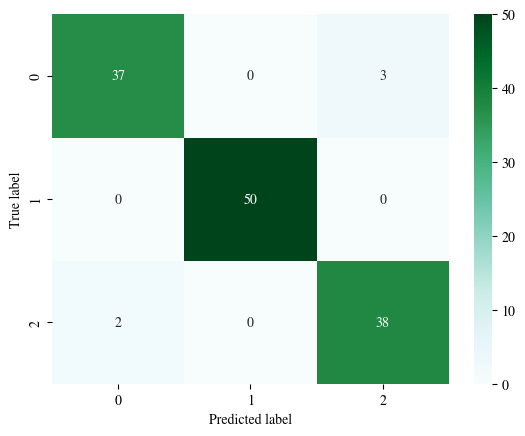

In [ ]:
confusion_matrix_plot(cnn_cm, "CNN", 0)

In [ ]:
cnn_class_report = classification_report(y_time_test, y_pred)
print(cnn_class_report)

              precision    recall  f1-score   support

         0.0       0.95      0.93      0.94        40
         1.0       1.00      1.00      1.00        50
         2.0       0.93      0.95      0.94        40

    accuracy                           0.96       130
   macro avg       0.96      0.96      0.96       130
weighted avg       0.96      0.96      0.96       130

